<h1><center>Sartorius: Cell Instance Segmentation</center></h1>
                                                      
<center><img src = "https://neurosciencenews.com/files/2019/09/motor-neurons-als-neurosciencenews-public.jpg" width = "750" height = "500"/></center>    

<h1><center>Load Modules</center></h1>

In [1]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null

In [2]:
# import module we'll need to import our custom module
from shutil import copyfile

# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/losses/Losses.py", dst = "../working/Losses.py")

'../working/Losses.py'

In [3]:
import os
import copy
import warnings

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torchvision
from torchvision.transforms import functional as F

from torch.utils.tensorboard import SummaryWriter
import cv2

import albumentations as A
import albumentations.pytorch
from albumentations import (HorizontalFlip, VerticalFlip, 
                            ShiftScaleRotate, Normalize, Resize, 
                            Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2

import random
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from tqdm import tqdm, tqdm_notebook

import pickle
from pathlib import Path
import PIL

import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import skimage

import time
import collections
import itertools
#import segmentation_models_pytorch as smp

from Losses import ComboLoss

In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

%matplotlib inline

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [5]:
def set_random(n):
    random.seed(n)
    np.random.seed(n)
    torch.manual_seed(n)
    torch.cuda.manual_seed(n)
    torch.cuda.manual_seed_all(n)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(n)
    
set_random(42)

In [6]:
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 450.119.04, 16280 MiB


<h1><center>Configurations</center></h1>

In [7]:
data_dir = '../input/sartorius-cell-instance-segmentation'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 4
NUM_EPOCHS = 30
TRAIN_CSV = f"{data_dir}/train.csv"
TRAIN_PATH = f"{data_dir}/train"
TEST_PATH = f"{data_dir}/test"
SAMPLE_SUBMISSION = f"{data_dir}/sample_submission.csv"

WIDTH = 704
HEIGHT = 520
# Threshold for mask length
TH = 40
LR = 1e-3
WEIGHT_DECAY = 0.0005


# Normalize to resnet mean and std if True.
RESNET_MEAN = [0.485, 0.456, 0.406]
RESNET_STD = [0.229, 0.224, 0.225]
IMAGE_RESIZE = (224, 224)


SAVE_MODEL = True
LOAD_MODEL = True

WORKERS = 2

cmap = mpl.colors.ListedColormap(['black', 'gray', 'orange', 'green'])

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Load the data</center></h2>

In [8]:
train_files = sorted(list(Path(TRAIN_PATH).rglob('*png')))
test_files = sorted(list(Path(TEST_PATH).rglob('*.png')))
print(f'Number of pictures in train dir: {len(train_files)} pcs')
print()
print(f'Number of pictures in test dir: {len(test_files)} pcs')

Number of pictures in train dir: 606 pcs

Number of pictures in test dir: 3 pcs


In [9]:
cell_df = pd.read_csv(TRAIN_CSV)
cell_df.info()
cell_df.sample(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


id                                         annotation  width  \
65518  de504eaa5349  252178 6 252881 8 253585 9 254288 10 254992 11...    704   
48139  a76fe4d00355  112202 6 112905 10 113608 11 114314 9 115018 9...    704   
37042  836e5872684a  268741 3 269440 10 270138 18 270839 23 271544 ...    704   
60537  d09291445961  125348 8 126050 11 126753 13 127457 15 128162 ...    704   

       height cell_type plate_time sample_date  \
65518     520    shsy5y  11h30m00s  2019-06-15   
48139     520    shsy5y  11h30m00s  2019-06-14   
37042     520    shsy5y  11h30m00s  2019-06-14   
60537     520     astro  09h00m00s  2020-09-14   

                                sample_id elapsed_timedelta  
65518  shsy5y[diff]_D12-1_Vessel-714_Ph_2   0 days 11:30:00  
48139  shsy5y[diff]_E10-2_Vessel-714_Ph_3   0 days 11:30:00  
37042  shsy5y[diff]_D12-4_Vessel-714_Ph_4   0 days 11:30:00  
60537  astros[cereb]_F8-2_Vessel-361_Ph_4   0 days 09:00:00

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Utilits</center></h2>

***Run Length Encoding: Annotation Data to Mask Image¶***

Next funtion is refferred to INVERSION's notebook'Run Length Decoding - Quick Start'.

https://www.kaggle.com/inversion/run-length-decoding-quick-start

***What is Run-length encoding (RLE)?***

Run-length encoding (RLE) is a form of lossless data compression in which runs of data (sequences in which the same data value occurs   in many consecutive data elements) are stored as a single data value and count, rather than as the original run. This is most efficient on data that contains many such runs, for example, simple graphic images such as icons, line drawings, Conway's Game of Life, and animations. For files that do not have many runs, RLE could increase the file size. (from Wikipedia)

#### [WIKI](https://en.wikipedia.org/wiki/Run-length_encoding)

In [10]:
def rle_decode(mask_rle,shape,color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    if colors = 1, then:
    Returns numpy array, 1 - mask, 0 - background
    '''
    
    s = mask_rle.split()
    # get starting pixel and cells's length
    start, length = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    start -=1
    # Ending pixels
    ends = start + length
    img = np.zeros((shape[0] * shape[1], shape [2]), dtype=np.float32)
    for lo, hi in zip (start, ends):
        img[lo : hi] = color
    return img.reshape(shape)

Masks have an abnormally long continuous lines.

The mask is not representative enough.

We can take only correct masks to train our model.

**Thanks** [Slavko Prytula](https://www.kaggle.com/slavkoprytula/mask-correction-mask-filtering-updated#Utils)

In [11]:
def clean_mask(mask):
    '''
    Function is called to identify whether the mask is broken
    returns True or False state and also returns a mask
    '''
    mask = mask > threshold_otsu(np.array(mask).astype(np.uint8))
    mask = ndi.binary_fill_holes(mask).astype(np.uint8)
    
    # New code for mask acceptance
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    c = contours[0][:, 0]
    diff = c - np.roll(c, 1, 0)
    # find horizontal lines longer than threshold
    targets = (diff[:, 1] == 0) & (np.abs(diff[:, 0]) >= TH)  
    
    return mask, (True in targets)

In [12]:
def build_mask(labels, input_shape, colors=True):
    height, width = input_shape
    masks = np.zeros((height, width, 1))
    #masks = np.zeros((height,width), dtype=np.uint8)
    for i, label in enumerate(labels):
        a_mask = rle_decode(label, shape=(height,width, 1))
        a_mask = np.array(a_mask) > 0 
        a_mask, broken_mask = clean_mask(a_mask)
        if broken_mask:
            continue
        masks += a_mask
    masks = masks.clip(0,1)
    return masks

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize the Data</center></h2>

--- 0.0010938644409179688 seconds in label ---
--- 0.010486841201782227 seconds in sorting df ---
--- 10.133565664291382 seconds in mask1 ---
--- 9.75171947479248 seconds in mask2 ---


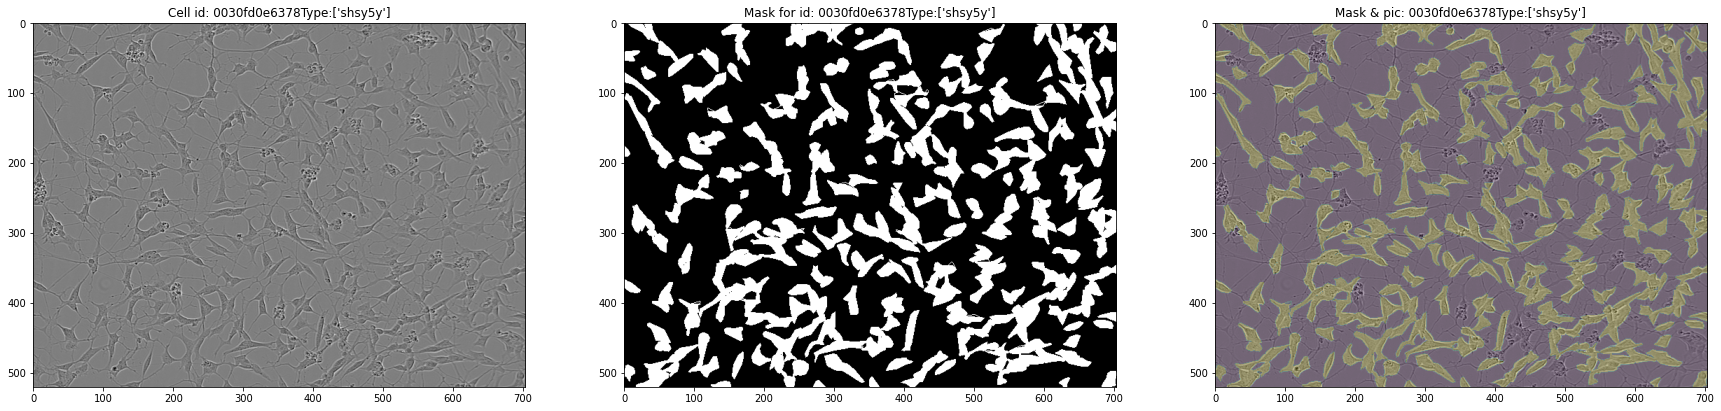

--- 0.0012521743774414062 seconds in label ---
--- 0.011565446853637695 seconds in sorting df ---
--- 2.125555992126465 seconds in mask1 ---
--- 2.2887990474700928 seconds in mask2 ---


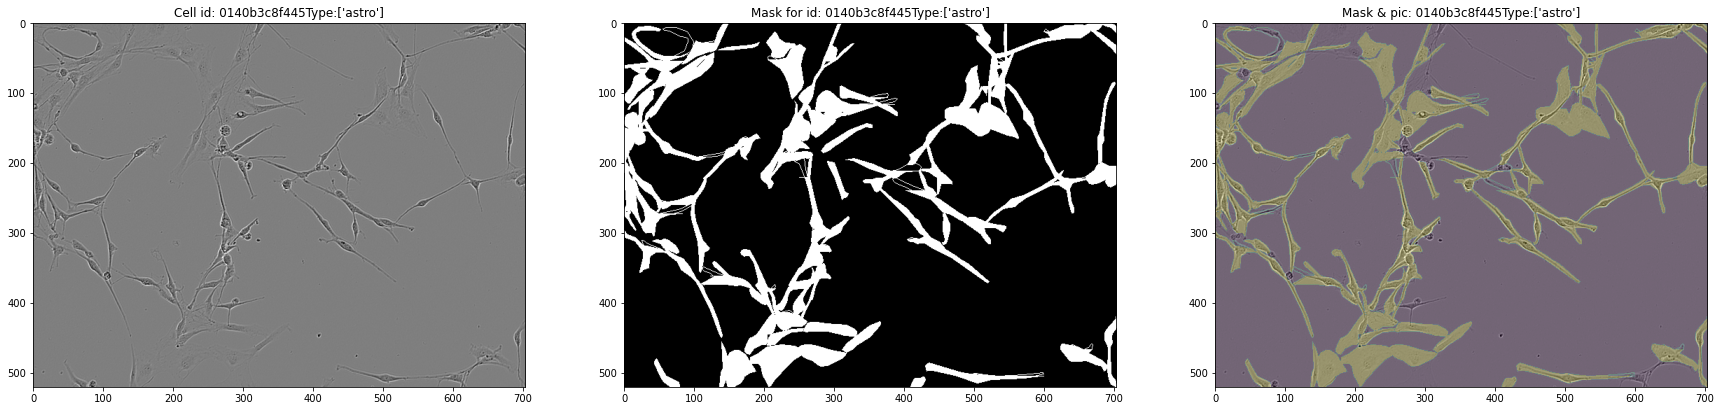

--- 0.0009453296661376953 seconds in label ---
--- 0.010226964950561523 seconds in sorting df ---
--- 0.7056245803833008 seconds in mask1 ---
--- 0.7050595283508301 seconds in mask2 ---


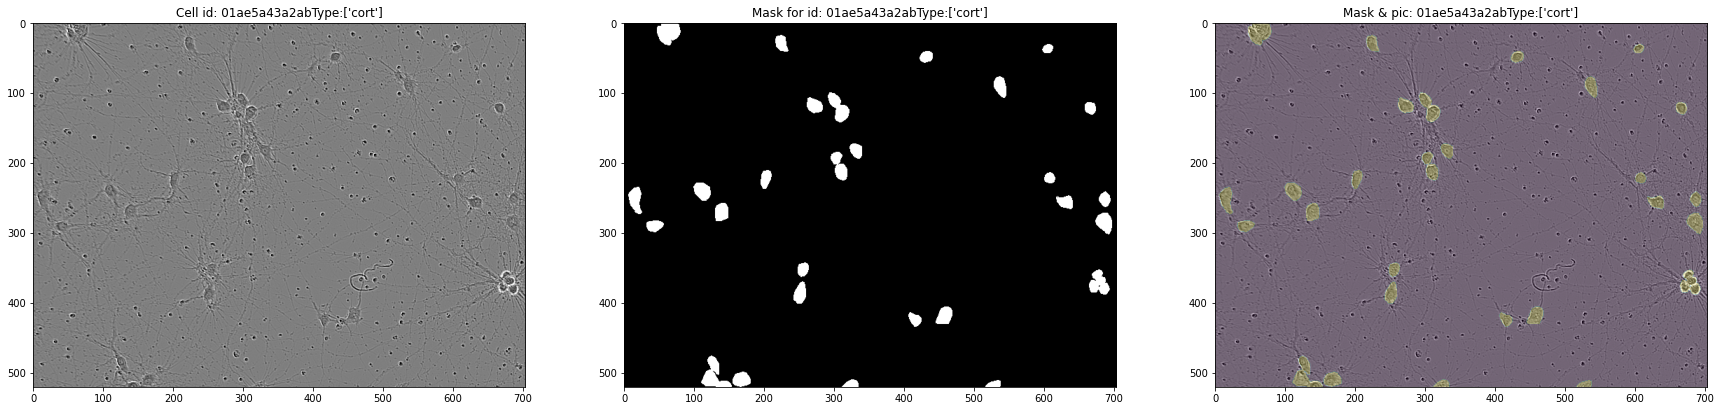

--- 0.0009627342224121094 seconds in label ---
--- 0.010483264923095703 seconds in sorting df ---
--- 0.8198785781860352 seconds in mask1 ---
--- 0.8478238582611084 seconds in mask2 ---


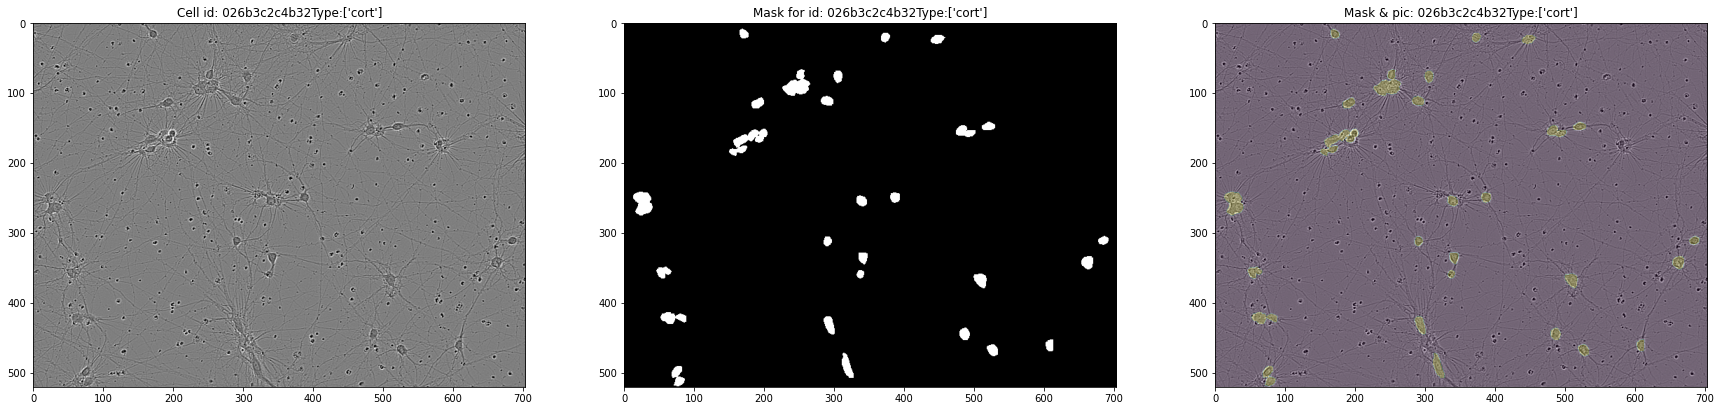

In [13]:
temp = cell_df.groupby(['id','cell_type'])['annotation'].agg(lambda x: list(x)).reset_index()
for i in range(4):
    #rand_idx = int(np.random.uniform(0, 607))
    #im = PIL.Image.open(train_files[rand_idx])
    im = PIL.Image.open(train_files[i])
    
    start = time.time()
    label = (train_files[i]).stem
    
    cell_type = temp[temp['id'] == label]
    cell_type = str(cell_type['cell_type'].values)
    print("--- %s seconds in label ---" % (time.time() - start))
    
    start = time.time()
    sample_im_df = cell_df[cell_df['id'] == label]
    print("--- %s seconds in sorting df ---" % (time.time() - start))
    
    sample_rles = sample_im_df['annotation'].values
    start = time.time()
    sample_masks1 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=False)
    print("--- %s seconds in mask1 ---" % (time.time() - start))
    
    start = time.time()
    sample_masks2 = build_mask(sample_rles,input_shape=(HEIGHT,WIDTH), colors=True)
    print("--- %s seconds in mask2 ---" % (time.time() - start))
    
    

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 20),)
    ax1.imshow(im,cmap='gray')
    ax2.imshow(sample_masks1, cmap='gray')
    ax3.imshow(im,cmap='gray')
    ax3.imshow(sample_masks2,alpha = .2)
    
    ax1.set_title('Cell id: ' + str(label) + 'Type:' + str(cell_type))
    ax2.set_title('Mask for id: ' + str(label) + 'Type:' + str(cell_type))
    ax3.set_title('Mask & pic: ' + str(label) + 'Type:' + str(cell_type))
    plt.show();
del temp, im, sample_masks1, sample_masks2

<h1><center>Preparing DataSets And DataLoaders</center></h1>

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Define Augmenting</center></h2>

In [14]:
def get_augmentation(pic_size,mode):
    if mode !='train':
        augmentation_test = albumentations.Compose([A.Resize(pic_size,pic_size),
                                                    A.Normalize(
                                                        mean=RESNET_MEAN,
                                                        std=RESNET_STD),
                                                    A.pytorch.transforms.ToTensorV2()])
        return augmentation_test
    else:
        augmentation_train = A.Compose([
            A.Resize(pic_size,pic_size),
            A.RandomCrop(pic_size, pic_size),
            A.OneOf([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                #A.VerticalFlip(p=0.5)
            ], p=0.5),
            A.OneOf([
                A.GaussNoise(),], p=0.8),

            A.OneOf([
                A.CLAHE(clip_limit=2),
                A.RandomBrightnessContrast(),], p=0.2),
#             A.HueSaturationValue(p=0.2),
            A.Normalize(
                mean=RESNET_MEAN,
                std=RESNET_STD),
            A.pytorch.transforms.ToTensorV2()], p=1)
        return augmentation_train

In [15]:
class NeuroDataSet(Dataset):
    def __init__(self, files, df: pd.core.frame.DataFrame,train:bool, transform=None):   
        self.files = files
        self.df = df
        self.height = HEIGHT
        self.width = WIDTH
        self.gb = self.df.groupby('id')
        self.transform = transform
        self.len_ = len(self.files)
        self.train = train
        
    
    def load_sample(self, file):
        img = cv2.imread(str(file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self,index):
        # load image
        img, img_id = self.load_sample(self.files[index])
        df_temp = self.gb.get_group(img_id)
        
        annotations = df_temp['annotation'].values
        mask = build_mask(annotations, (self.height,self.width), colors=False)
        mask = mask.astype('float32')
        if self.transform is not None:
            augmented = self.transform(image = img, mask = mask)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
        else:
            return img, mask.reshape((1, IMAGE_RESIZE[0], IMAGE_RESIZE[1]))
     
    def __len__(self):
        return self.len_

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Split train-val set</center></h2>

In [16]:
# Split dataset to train and val sets
train_pics, val_pics = train_test_split(train_files, test_size=0.1)

In [17]:
# Extract pic Id from Path
train_pic_id = [path.stem for path in train_pics]
val_pic_id = [path.stem for path in val_pics]
# Print number of files in tran and val sets
print(f'Number of pictures in train set: {len(train_pics)}')
print()
print(f'Number of pictures in val set: {len(val_pics)}')

Number of pictures in train set: 545

Number of pictures in val set: 61


In [18]:
# split pandas dataframe with annotations for train df and val df
# in consistance with given file Ids
df_train = cell_df[(cell_df['id'].isin(train_pic_id))]
df_val = cell_df[(cell_df['id'].isin(val_pic_id))]

print(f"Number of picture's id in train set {df_train.id.nunique()}")
print()
print(f"Number of picture's id in val set {df_val.id.nunique()}")

Number of picture's id in train set 545

Number of picture's id in val set 61


In [19]:
train_dataset = NeuroDataSet(train_pics,
                             df_train,
                             train = True,
                             transform=get_augmentation(224, 'train')
                            )

In [20]:
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

In [21]:
val_dataset = NeuroDataSet(val_pics,
                           df_val,train=False,
                          transform=get_augmentation(224, 'val')
                          )

In [22]:
val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

In [23]:
batch = next(iter(train_loader)) 
images, masks = batch
print(f"image shape: {images.shape},\nmask shape:{masks.shape},\nbatch len: {len(batch)}")
del batch, images, masks

image shape: torch.Size([4, 3, 224, 224]),
mask shape:torch.Size([4, 1, 224, 224]),
batch len: 2


<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize Augmented DataSet</center></h2>

In [24]:
def visualize_augmentations(dataset, idx=1, samples=9, cols=3):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, A.pytorch.ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 12))
    for i in range(samples):
        image, mask = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    del dataset

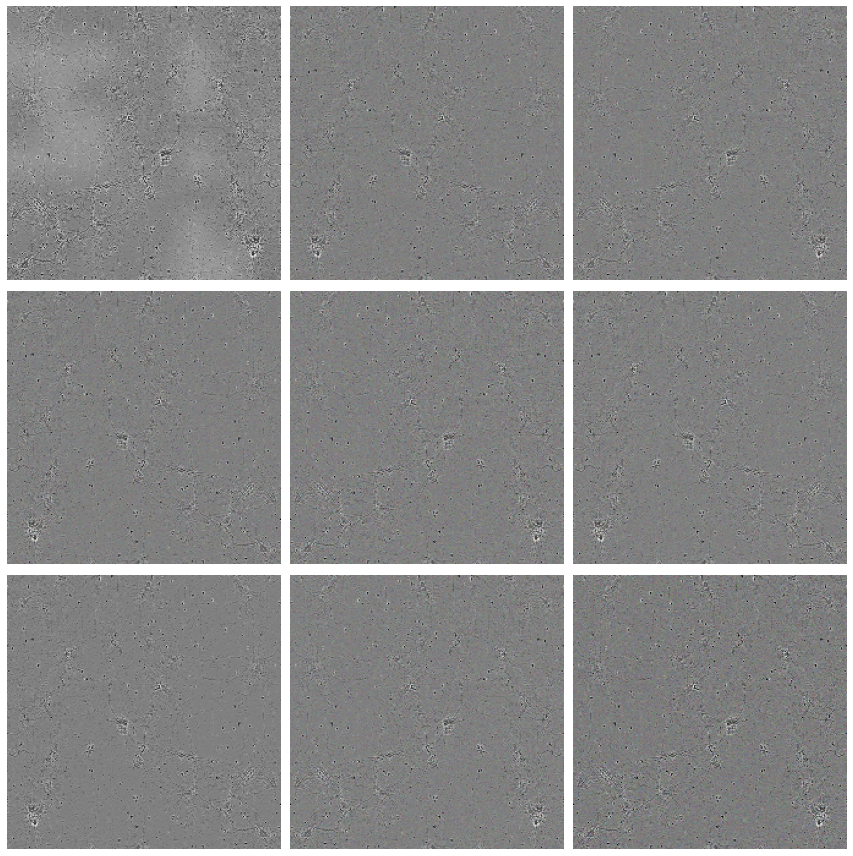

In [25]:
visualize_augmentations(train_dataset,idx=3)

<h1><center>UNET from SCRATCH</center></h1>

In [26]:
# Create convolution block class
class Conv_Block(nn.Module):
    '''convolution ==> BN ==> ReLU'''
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [27]:
class Encoder(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            Conv_Block(in_channels, out_channels),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = x.cuda()
        return self.maxpool_conv(x)

In [28]:
class Decoder(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            
        self.conv = Conv_Block(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = x1.cuda()
        x2 = x2.cuda()
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

In [29]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        
        self.inc = Conv_Block(n_channels, 64)
        self.enc1 = Encoder(64, 128)
        self.enc2 = Encoder(128, 256)
        self.enc3 = Encoder(256, 512)
        self.enc4 = Encoder(512, 512)
        self.dec1 = Decoder(1024, 256, bilinear)
        self.dec2 = Decoder(512, 128, bilinear)
        self.dec3 = Decoder(256, 64, bilinear)
        self.dec4 = Decoder(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        x = self.dec1(x5, x4)
        x = self.dec2(x, x3)
        x = self.dec3(x, x2)
        x = self.dec4(x, x1)
        logits = self.outc(x)
        return logits

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Define loss functions</center></h2>

In [31]:
from Losses import ComboLoss
# JaccardLoss = smp.losses.JaccardLoss(mode='binary') 
# Dice        = smp.losses.DiceLoss(mode='binary',)
# BCELoss     = smp.losses.SoftBCEWithLogitsLoss()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Define Save Weights function</center></h2>

In [32]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

In [33]:
def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Train</center></h2>

In [34]:
def train_loop(model, optimizer, criterion, train_loader, device=DEVICE):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0]  # += loss * current batch size
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    del imgs, masks
    torch.cuda.empty_cache()
    return running_loss

In [35]:
@torch.no_grad()
def eval_loop(model, criterion, eval_loader, device=DEVICE):
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss}

In [36]:
@torch.no_grad()
def visualize_train(model,val_loader, device=DEVICE):
    model.eval()
    X_val, Y_val = next(iter(val_loader))
    Y_hat = model(X_val.to(device))
    
    Y_hat = torch.tanh(Y_hat)
    Y_hat = Y_hat.detach().cpu().numpy()
    X_val = X_val.detach().cpu().numpy()
    
    #clear_output(wait=True)
    for k in range(2):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5),)
        ax1.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3),cmap='gray')
        ax2.imshow(((Y_hat[k, 0] * 255)), cmap='gray')
        ax1.set_axis_off()
        ax2.set_axis_off()
        ax1.set_title('Real')
        ax2.set_title('Output')
    plt.show()
    del X_val, Y_hat

In [37]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=DEVICE, 
          num_epochs=NUM_EPOCHS, 
          valid_loss_min=np.inf,
          vis=False,
          model_name=None):
    #step = 0
    history = []
       
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        torch.cuda.empty_cache() #!!!!!!!!!!!!!!!!!
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        history.append((train_loss,metrics["loss"],metrics["accuracy"],metrics["f1_macro"]))
        
        #writer = SummaryWriter(f"runs/Sartorius LR_{LR}_BS_{BATCH_SIZE}")
        # visualize model in tensorboard
        images, masks = next(iter(train_loader))
        #writer.add_graph(model, images.to(device))
        #writer.close()
        
        if vis:
            visualize_train(model,val_loader,device=DEVICE)
        
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print(print_string)


        # save the model 
        if SAVE_MODEL and metrics["loss"] <= valid_loss_min:
            save_checkpoint(model, optimizer, filename=model_name)
            valid_loss_min = metrics["loss"]

    return history

In [38]:
model = UNet(3, 1).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY )
criterion        = ComboLoss(**{'weights':{'dice':3, 'focal':2, 'jaccard':3}})

In [39]:
# copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/d/pauldark/u-net-loss/Unet_combo.pth", dst = "../working/Unet_combo.pth")

'../working/Unet_combo.pth'

In [40]:
CHECKPOINT = 'Unet_combo.pth'

In [41]:
if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT, model, optimizer, LR,
        )

=> Loading checkpoint


In [42]:
# history = train(model, optimizer, criterion, train_loader, val_loader, model_name=CHECKPOINT)

Let' download weights of trained model.

In [43]:
# Load the latest model data_dir
# if LOAD_MODEL:
#         load_checkpoint(
#             CHECKPOINT, model, optimizer, LR,
#         )
        
# metrics = eval_loop(model, criterion, val_loader)
# print('accuracy:', metrics['accuracy'])
# print('f1 macro:', metrics['f1_macro'])
# print('test loss:', metrics['loss'])

In [44]:
# #del metrics
# torch.cuda.empty_cache()
# del model

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Visualize Training Results</center></h2>

Let's check loss and accuracies during the training of the model

In [45]:
def plot_loss_acc(history):
    """Print Loss in train and val sets"""
    train_loss, val_loss, val_acc, _ = zip(*history)

    fig, (ax1, ax2) = plt.subplots(2, figsize=(10,10))
    fig.suptitle('Loss and Accuracy')
    ax1.plot(train_loss, label="train_loss")
    ax1.plot(val_loss, label="val_loss")
    ax1.legend(loc='best')
    plt.ylabel("loss")

    ax2.plot(val_acc, label="val_accuracy")
    ax2.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [46]:
# plot_loss_acc(history)

Inspired by:

[Ant 🐜 ](https://www.kaggle.com/superant/simple-nn-segmentation/notebook)

In [47]:
def get_threshold(Y, pred):
    '''Function is called for finding threshols and IoU
    '''
    scores = list(pred.ravel())
    mask = list(Y.ravel())
    
    #idx from the end to the begining
    idxs=np.argsort(scores)[::-1]
    mask_sorted=np.array(mask)[idxs]
    sum_mask_one=np.cumsum(mask_sorted)
    IoU=sum_mask_one/(np.arange(1,len(mask_sorted)+1)+np.sum(mask_sorted)-sum_mask_one)
    best_IoU_idx=IoU.argmax()
    best_threshold=scores[idxs[best_IoU_idx]]
    best_IoU=IoU[best_IoU_idx]

    return best_threshold, best_IoU

Re-assign val_loader with higher num of batches (for further plotting)


In [48]:
val_loader_plot = DataLoader(val_dataset,
                          batch_size=16,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

Define function to get the best value of threshold for the IoU metric

In [49]:
@torch.no_grad()
def get_best_threshold(model,loader,device=DEVICE,N=3):
    img_thresholds = []
    img_IoUs = []
    model.eval()
    
    for img, mask in tqdm(itertools.islice(loader, N), total=N):
        img = img.to(device)
        mask = mask.detach().numpy()
        
        Y_hat = torch.sigmoid(model(img)).cpu().detach().numpy()
        
        for i in range(mask.shape[0]):
            best_img_threshold, best_img_IoU = get_threshold(mask[i], Y_hat[i])
            img_thresholds.append(best_img_threshold)
            img_IoUs.append(best_img_IoU)
    del model #！！！！！！！！！！！！！！！！！！！        
    return img_thresholds,img_IoUs

In [50]:
img_thresholds,img_IoUs = get_best_threshold(model,val_loader_plot)

100%|██████████| 3/3 [03:05<00:00, 61.86s/it]


In [51]:
best_threshold = np.mean(img_thresholds)
threshold_std = np.std(img_thresholds)
avg_IoU = np.mean(img_IoUs)

print(f"Best threshold: {best_threshold:.3g} (STD: +-{threshold_std:.3g}), Avg. Val IoU: {avg_IoU:.3f}")

Best threshold: 0.437 (STD: +-0.285), Avg. Val IoU: 0.540


In [52]:
threshold = best_threshold
model.eval()

X, Y = next(iter(val_loader_plot))
X = X.to(DEVICE)
Y = Y.detach().numpy()

with torch.no_grad():
    pred=torch.sigmoid(model(X)).cpu().detach().numpy()
    
pred_Y = (pred >= threshold)
del X

Define a function to plot Real mask, Predicted mask and Overlapping mask with following colors:

***green: correct prediction***

***gray: false positive (too much)***

***orange: false negative (missed)***

In [53]:
def plot(Y_val, Y_hat):
    output = np.zeros_like(Y_val)
    output = np.where((Y_val == 0) & (Y_hat == 1), 1, output)
    output = np.where((Y_val == 1) & (Y_hat == 0), 2, output)
    output = np.where((Y_val == 1) & (Y_hat == 1), 3, output)

    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 15),)
    ax1.imshow(Y_val,cmap='gray')
    ax2.imshow(((Y_hat * 255)), cmap='gray')
    ax3.imshow(output, cmap=cmap)
    ax1.set_axis_off()
    ax2.set_axis_off()
    ax3.set_axis_off()
    ax1.set_title('Real')
    ax2.set_title('Output')
    ax3.set_title('Real+Output')
    plt.xticks([])
    plt.yticks([]);

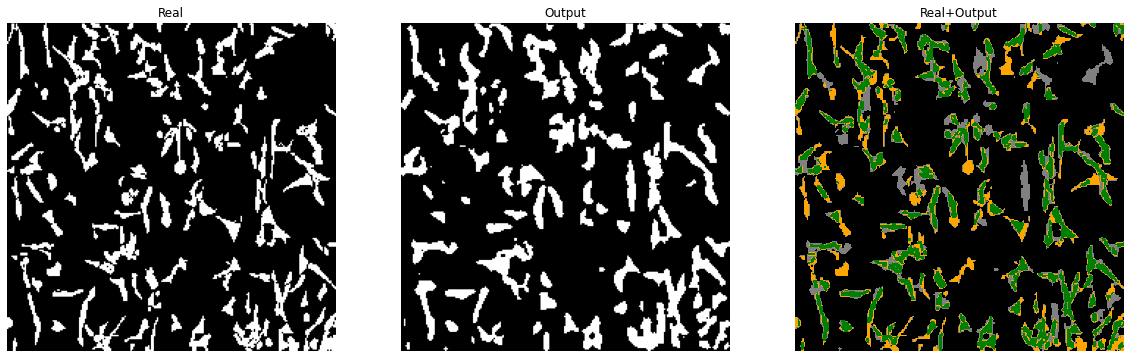

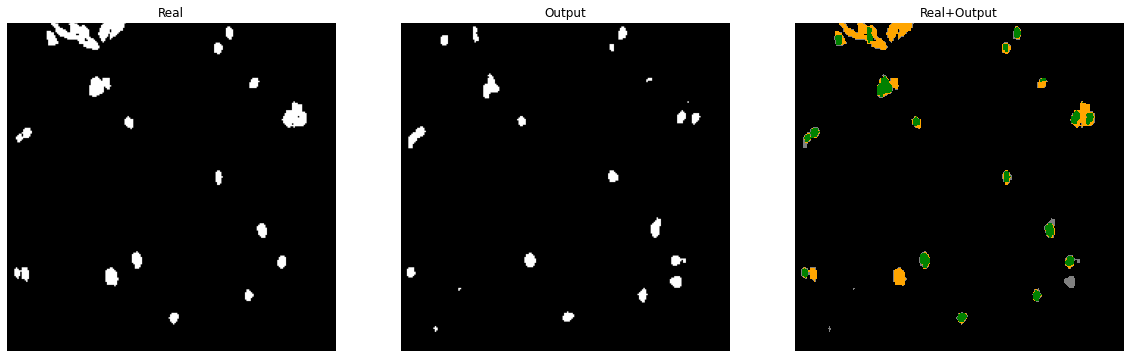

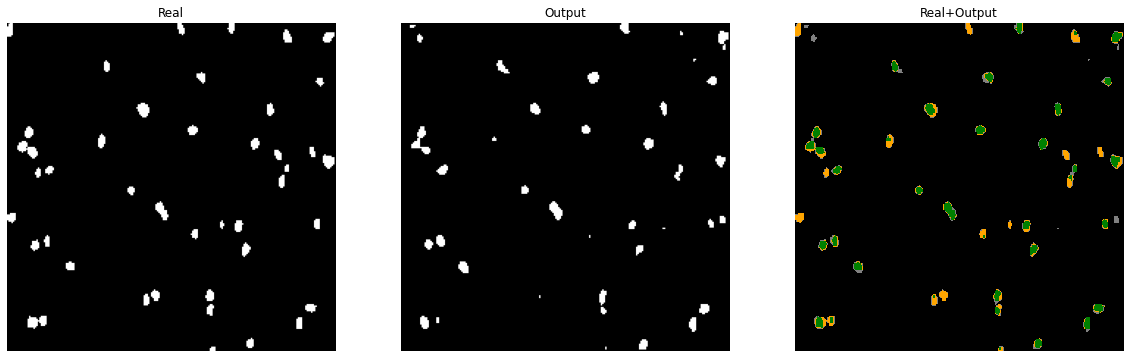

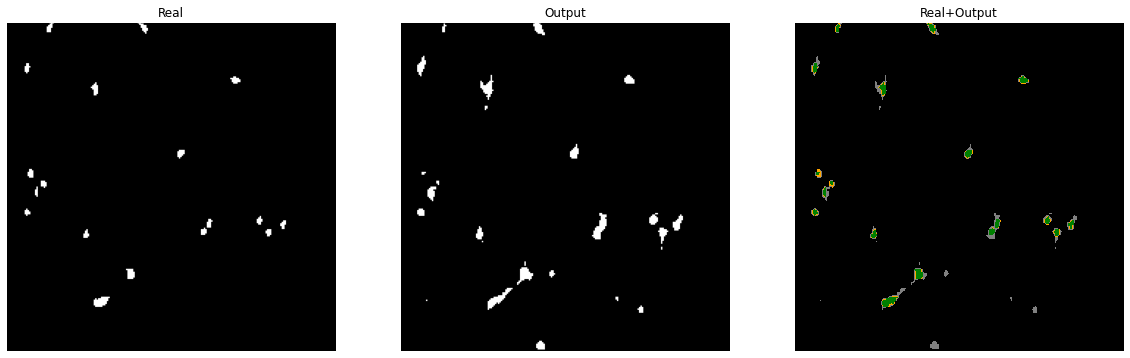

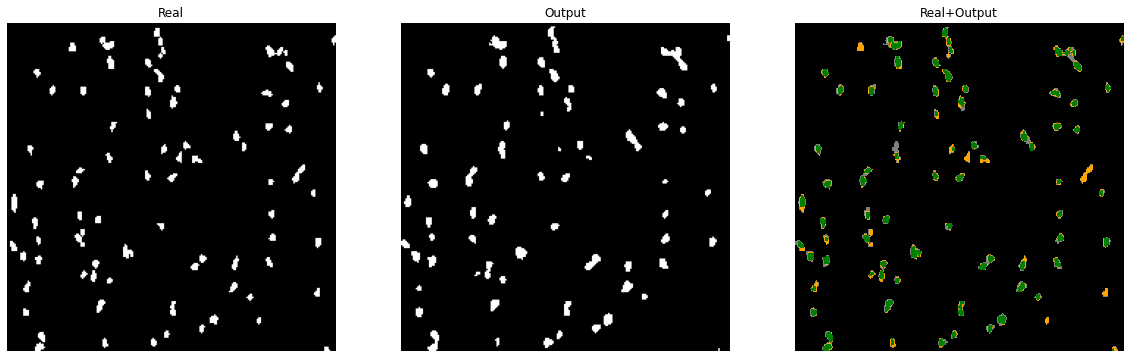

In [54]:
N = 5
for i in range(N):
    img_Y = Y[i, 0]
    img_pred = pred_Y[i, 0]
    
    plot(img_Y, img_pred)
    plt.show()

<h2 class="list-group-item list-group-item-action active" data-toggle="list" style='background:orange; border:0; color:white' role="tab" aria-controls="home"><center>Save Results to a Pandas DataFrame </center></h2>

In [55]:
def get_scores(report_df,
               name,loss_name, img_IoUs, 
               img_thresholds,metrics = None,
               history = None,
               load_weight = False):
    '''Create and add metrics into a pandas DF after experiment'''
    
    report = pd.DataFrame(columns={'Criterion'}, data=[0])
    
    if load_weight:
        train_loss, val_loss, val_acc, f1_macro = zip(*history)
        report['Validation_loss'] = val_loss[-1]
        report['Val_Acc_at_last_epoch'] = val_acc[-1]
        report['Mean_acc_in_val_set'] = np.mean(val_acc)
        report['F1_macro'] = f1_macro[-1]
        report['mean_F1_along_epochs'] = np.mean(f1_macro)

    
    report['Criterion'] = loss_name
    report['Average_Val_IoU'] = np.mean(img_IoUs)
    report['Best_threshold'] = np.mean(img_thresholds)

    report.index = [name]
    report_df = report_df.append(report)
    return report_df

In [56]:
df_report = pd.DataFrame(data=None)

In [57]:
df_report = get_scores(df_report, 'Unet_BaseLine', 'ComboLoss',
                      img_IoUs,img_thresholds)
df_report

Criterion  Average_Val_IoU  Best_threshold
Unet_BaseLine  ComboLoss         0.539752        0.437438

<h1><center>SUBMISSION</center></h1>

Define function for encoding masks

In [58]:
class NeuroDataSet(Dataset):
    def __init__(self, files, transform=None):   
        self.files = files
        self.height = HEIGHT
        self.width = WIDTH
        self.transform = transform
        self.len_ = len(self.files)
        
    
    def load_sample(self, file):
        img = cv2.imread(str(file), cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_id = file.stem
        return img, img_id
    
    def __getitem__(self,index):
        # load image
        img, img_id = self.load_sample(self.files[index])
        
        if self.transform is not None:
            augmented = self.transform(image = img)
            img = augmented['image']
            return img,img_id
        else:
            return img,img_id
     
    def __len__(self):
        return self.len_

In [59]:
test_dataset = NeuroDataSet(test_files,
                             transform=get_augmentation(224, 'test')
                            )

In [60]:
test_loader = DataLoader(test_dataset,
                          batch_size=3,
                          shuffle=False,
                          pin_memory=True,
                          num_workers=WORKERS,)

# Utilities

In [61]:
@torch.no_grad()
def predict_mask(image,model,device=DEVICE):
    model.eval()
#     image = image.view(-1,3,224,224)
    image = image.to(device)
    y_pred = torch.sigmoid(model(image)).cpu().detach().numpy()
#     y_pred = np.squeeze(y_pred,axis=0)
    return y_pred

In [62]:
img, im_id = next(iter(test_loader))
preds_test = predict_mask(img,model)
#preds_test = preds_test >= threshold

In [63]:
def mask_convert(mask):
    #mask = mask.clone().cpu().detach().numpy()
    mask = mask.transpose((1,2,0))
    mask = np.squeeze(mask)
    return mask

In [64]:
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))

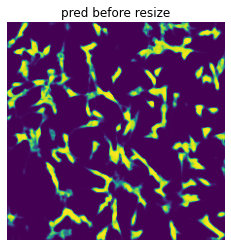

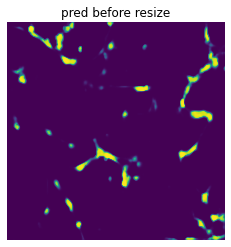

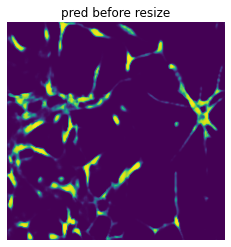

In [65]:
for pred in preds_test:
    pred = mask_convert(pred)
    plt.imshow(pred)
    plt.title('pred before resize')
    plt.axis("off")
    plt.show()

(520, 704, 1)


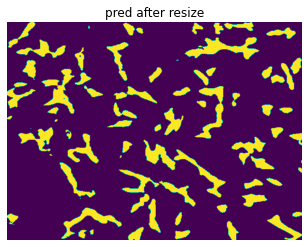

(520, 704, 1)


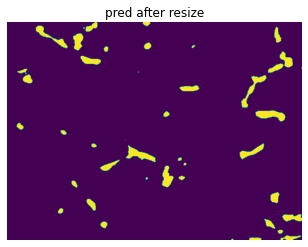

(520, 704, 1)


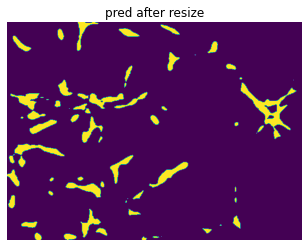

In [66]:
#test_mask: after reshape before fix_overlapping
test_masks = []
for pred in preds_test:
    pred = mask_convert(pred)
    test_mask=cv2.resize(pred,dsize=(704,520),interpolation=cv2.INTER_CUBIC).reshape(520,704,1)
    print(test_mask.shape)
    test_mask = test_mask >= threshold
    test_masks.append(test_mask)
        
    plt.imshow(test_mask)
    plt.title('pred after resize')
    plt.axis("off")
    plt.show()

In [67]:
print(test_masks[0].shape)


(520, 704, 1)


In [68]:
def check_overlap(msk):
    msk = msk.astype(np.bool).astype(np.uint8)
    return np.any(np.sum(msk, axis=-1)>1)

In [69]:
import tensorflow as tf

In [70]:
def fix_overlap(msk):
    """
    Args:
        mask: multi-channel mask, each channel is an instance of cell, shape:(520,704,None)
    Returns:
        multi-channel mask with non-overlapping values, shape:(520,704,None)
    """
    msk = np.array(msk)
    msk = np.pad(msk, [[0,0],[0,0],[1,0]])
    ins_len = msk.shape[-1]
    msk = np.argmax(msk,axis=-1)
    msk = tf.keras.utils.to_categorical(msk, num_classes=ins_len)
    msk = msk[...,1:]
    msk = msk[...,np.any(msk, axis=(0,1))]
    return msk

In [71]:
for test_mask in test_masks:
    overlap_test_masks=check_overlap(test_mask)
    print(overlap_test_masks)

False
False
False


In [72]:
#test_mask2: after reshape after fix_overlapping
test_masks2=[]
for test_mask in test_masks:
    test_mask2 = fix_overlap(test_mask).reshape(520,704,1)
    print(test_mask2.shape)
    test_masks2+=[test_mask2]

(520, 704, 1)
(520, 704, 1)
(520, 704, 1)


In [73]:
for test_mask2 in test_masks2:
    overlap_test_masks2=check_overlap(test_mask2)
    print(overlap_test_masks2)

False
False
False


In [74]:
predicted2 = [rle_encoding(test_mask2) for test_mask2 in test_masks2]

In [75]:
for img,img_name in test_loader:
    masks = predict_mask(img,model)
    print(masks.shape)

(3, 1, 224, 224)


In [76]:
sample_submission=pd.read_csv(SAMPLE_SUBMISSION)
sample_submission

id  predicted
0  7ae19de7bc2a        NaN
1  d48ec7815252        NaN
2  d8bfd1dafdc4        NaN

In [77]:
submit = sample_submission.copy()
submit['predicted'] = predicted2
#submit.to_csv('submission.csv', index=False)
submit

id                                          predicted
0  7ae19de7bc2a  57 9 569 1 582 3 759 11 1272 4 1284 6 1461 15 ...
1  d48ec7815252  211 4 326 16 914 6 1029 18 1616 9 1733 18 2318...
2  d8bfd1dafdc4  170 18 204 8 874 19 905 14 1578 49 2283 48 298...

In [78]:
ids=sample_submission['id'].tolist()
print(ids)
submit2=pd.DataFrame(columns=sample_submission.columns)  

for idi, test_mask2 in zip(ids,test_masks2):
    annos=rle_encoding(test_mask2)
    annos2=annos.split(' ')
    annos4=[]
    for i in range(len(annos2)//100):
        annos3=''
        for j in range(100):
            annos3+=annos2[i*100+j]+' '
        annos4+=[annos3]
        
    submit=pd.DataFrame(columns=sample_submission.columns)    
    submit['predicted']=annos4
    submit['id']=idi
    submit2=pd.concat([submit2,submit],axis=0)
submit2=submit2.reset_index(drop=True)
    
submit2.to_csv('submission.csv', index=False)
submit2

['7ae19de7bc2a', 'd48ec7815252', 'd8bfd1dafdc4']


id                                          predicted
0    7ae19de7bc2a  57 9 569 1 582 3 759 11 1272 4 1284 6 1461 15 ...
1    7ae19de7bc2a  6830 20 6857 69 7088 18 7235 3 7320 23 7485 21...
2    7ae19de7bc2a  11574 14 11708 25 11762 20 11794 5 11838 14 11...
3    7ae19de7bc2a  16117 59 16231 13 16480 15 16505 13 16636 10 1...
4    7ae19de7bc2a  22561 18 23153 9 23197 15 23265 16 23900 15 23...
..            ...                                                ...
109  d8bfd1dafdc4  290153 5 290260 12 290358 12 290766 4 290858 3...
110  d8bfd1dafdc4  302023 13 302299 4 302562 2 302727 13 303004 2...
111  d8bfd1dafdc4  325445 9 325796 2 326149 10 326498 4 326853 11...
112  d8bfd1dafdc4  338832 13 339166 16 339363 37 339508 22 339537...
113  d8bfd1dafdc4  349655 18 350068 14 350102 23 350360 16 350772...

[114 rows x 2 columns]

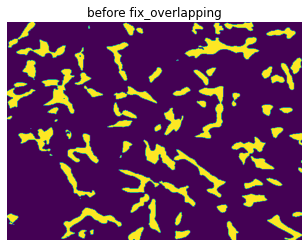

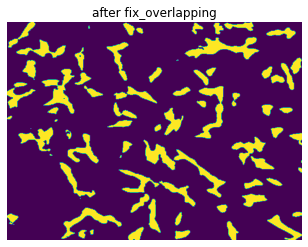

In [79]:
plt.imshow(test_masks[0])
plt.title('before fix_overlapping')
plt.axis("off")
plt.show()

plt.imshow(test_masks2[0])
plt.title('after fix_overlapping')
plt.axis("off")
plt.show()

## NERABOTAYUSHAYA HERNYA

In [80]:
# def rle_encoding(x):
#     dots = np.where(x.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return ' '.join(map(str, run_lengths))


# def remove_overlapping_pixels(mask, other_masks):
#     for other_mask in other_masks:
#         if np.sum(np.logical_and(mask, other_mask)) > 0:
#             mask[np.logical_and(mask, other_mask)] = 0
#     return mask

In [81]:
# # converting tensor to image
# def image_convert(image):
#     image = image.clone().cpu().numpy()
#     image = image.transpose((1,2,0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image  = std * image + mean
#     image = image.clip(0,1)
#     image = (image * 255).astype(np.uint8)
#     return image

# def mask_convert(mask):
#     #mask = mask.clone().cpu().detach().numpy()
#     mask = mask.transpose((1,2,0))
#     mask = np.squeeze(mask)
#     return mask

In [82]:
# def plot(img, Y_hat):
    
#     img = image_convert(img)
#     Y_hat = mask_convert(Y_hat)
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 15),)
#     ax1.imshow(img,)
#     ax2.imshow((Y_hat), cmap='seismic')
# #     ax2.imshow(((Y_hat * 255)), cmap='gray')
#     ax1.set_axis_off()
#     ax2.set_axis_off()
#     ax1.set_title('Real')
#     ax2.set_title('Output')
#     plt.xticks([])
#     plt.yticks([]);

In [83]:
# @torch.no_grad()
# def predict_mask(image,model,device=DEVICE):
#     model.eval()
#     image = image.view(-1,3,224,224)
#     image = image.to(device)
#     y_pred = torch.sigmoid(model(image)).cpu().detach().numpy()
#     y_pred = np.squeeze(y_pred,axis=0)
#     return y_pred

In [84]:
# threshold = best_threshold
# submission = []
# img, img_id = next(iter(test_loader))
# for i, im_id in enumerate(img_id):
#     previous_masks = []
#     result = predict_mask(img[i],model) 
#     binary_mask = (result >= threshold) 
#     #binary_mask = result > 0.5
#     binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
#     previous_masks.append(binary_mask)
#     rle = rle_encoding(binary_mask)
#     submission.append((im_id, rle))
#     plot(img[i],binary_mask)
    
#     all_images_ids = [im_id for im_id, rle in submission]
#     if im_id not in all_images_ids:
#         submission.append((im_id, ""))


In [85]:
# df_sub = pd.DataFrame(submission, columns=['id', 'predicted'])
# df_sub.to_csv("submission.csv", index=False)
# df_sub

HEROVAYA HERNYA

In [86]:
# test_dataset = NeuroDataSet(test_files,
#                              transform=get_augmentation(224, 'test')
#                             )

# test_loader = DataLoader(test_dataset,
#                           batch_size=3,
#                           shuffle=False,
#                           pin_memory=True,
#                           num_workers=WORKERS,)

In [87]:
# for image,img_id in test_loader:
#     print(img_id)
#     print(image.shape)
#     break

In [88]:
# @torch.no_grad()
# def predict_mask(image,model,device=DEVICE):
#     model.eval()
#     image = image.to(device)
#     y_pred = torch.sigmoid(model(image)).cpu().detach().numpy()
#     return y_pred

# def mask_convert(mask):
#     #mask = mask.clone().cpu().detach().numpy()
#     mask = mask.transpose((1,2,0))
#     mask = np.squeeze(mask)
#     return mask

# # converting tensor to image
# def image_convert(image):
#     image = image.clone().cpu().numpy()
#     image = image.transpose((1,2,0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     image  = std * image + mean
#     image = image.clip(0,1)
#     image = (image * 255).astype(np.uint8)
#     return image

In [89]:
# for img,img_names in test_loader:
#     masks = predict_mask(img,model)
#     for i,mask in enumerate(masks):
#         mask = mask_convert(mask)
#         mask = np.where(mask > 0.5, 1, 0)
#         image = img[i]
#         image = image_convert(image)
#         fig,axes = plt.subplots(1,2,figsize=(16,7))
#         axes[0].imshow(image)
#         axes[0].set_title('Image')
#         axes[1].imshow(mask,cmap="gray")
#         axes[1].set_title('Predicted Mask')
#         plt.suptitle(img_names[i])
#         plt.tight_layout()
#         plt.show()

In [90]:
# def ins2rle(ins):
#     '''
#     img: numpy array, 1 - mask, 0 - background
#     Returns run length as string formated
#     '''
#     ins    = np.array(ins)
#     pixels = ins.flatten()
#     pad    = np.array([0])
#     pixels = np.concatenate([pad, pixels, pad])
#     runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     rles = ' '.join(str(x) for x in runs)
#     return rles

# def mask2rle(mask, cutoff=0.5, min_object_size=1.0):
#     """ Return run length encoding of mask. 
#         ref: https://www.kaggle.com/raoulma/nuclei-dsb-2018-tensorflow-u-net-score-0-352
#     """
#     # segment image and label different objects
#     lab_mask = skimage.morphology.label(mask > cutoff)
    
     
#     # Keep only objects that are large enough.
#     (mask_labels, mask_sizes) = np.unique(lab_mask, return_counts=True)
    

#     if (mask_sizes < min_object_size).any():
# #         print(mask_sizes)
#         mask_labels = mask_labels[mask_sizes < min_object_size]
        
#         for n in mask_labels:
#             lab_mask[lab_mask == n] = 0
#         lab_mask = skimage.morphology.label(lab_mask > cutoff) 
        
#     rles = []
#     # Loop over each object excluding the background labeled by 0.
#     for i in range(1, lab_mask.max() + 1):
#         rle = ins2rle(lab_mask == i)
#         rles.append(rle)
        
#     return rles


In [91]:
# pred_rles , pred_paths = [],[]
# for img,img_name in test_loader:
#     masks = predict_mask(img,model)
#     for i,mask in enumerate(masks):
#         mask = mask_convert(mask)
#         msk = cv2.resize(mask,(704,520),interpolation=cv2.INTER_NEAREST)
#         rle_list = mask2rle(msk)
#         img_id = img_name[i].split('.')[0]
#         idx_list = [img_id for i in range(len(rle_list))] 
#         pred_rles.extend(rle_list)
#         pred_paths.extend(idx_list)

In [92]:
# df = pd.DataFrame({'id':pred_paths, 'predicted':pred_rles})
# df.to_csv('submission.csv', index=False)
# df = pd.read_csv('submission.csv')
# df